In [2]:
import numpy as np
import pandas as pd
import operator
import pickle
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, cross_validation
from sklearn.cross_validation import train_test_split
from sklearn import linear_model

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler, SMOTE
import warnings
warnings.filterwarnings(action='once')

import xgboost
from xgboost import XGBClassifier
from sklearn.tree import export_graphviz
import graphviz
#from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import *
import warnings
warnings.filterwarnings(action='once')
from sklearn.model_selection import StratifiedKFold
from scipy import interp
from itertools import cycle

In [21]:
X = pd.read_pickle('../../Data/Opioids/Model_Data/SMOTE/X.pickle')
y = np.load('../../Data/Opioids/Model_Data/SMOTE/y.pickle')
X_resampled = np.load('../../Data/Opioids/Model_Data/SMOTE/X_resampled.pickle')
y_resampled = np.load('../../Data/Opioids/Model_Data/SMOTE/y_resampled.pickle')
X_res_vis = np.load('../../Data/Opioids/Model_Data/SMOTE/X_res_vis.pickle')
X_vis = np.load('../../Data/Opioids/Model_Data/SMOTE/X_vis.pickle')
X_train = pd.read_pickle('../../Data/Opioids/Model_Data/SMOTE/X_train.pickle')
Y_train = pd.read_pickle('../../Data/Opioids/Model_Data/SMOTE/Y_train.pickle')
X_test = pd.read_pickle('../../Data/Opioids/Model_Data/SMOTE/X_test.pickle')
Y_test = pd.read_pickle('../../Data/Opioids/Model_Data/SMOTE/Y_test.pickle')

In [4]:
X_res_vis.shape

(39938, 26)

Text(0.5,1,'Principle Component Analysis')

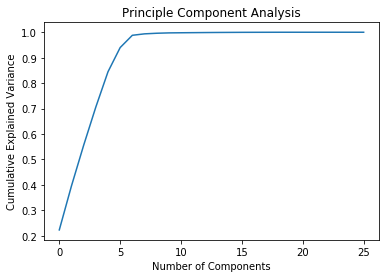

In [22]:
pca = PCA().fit(X_res_vis)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Principle Component Analysis')

In [7]:
pca = PCA(n_components=11).fit(X_res_vis)
pca.n_components_

11

In [9]:
X_pca = pca.transform(X_res_vis)
filtered = pca.inverse_transform(X_pca)

In [10]:
X_pca.shape

(39938, 11)

In [11]:
X_train_pca, X_test_pca, Y_train_pca, Y_test_pca = train_test_split(X_pca, y_resampled, test_size=0.2, random_state=42)

# The above returns numpy arrays. Converting them to data frames:
X_train_pca = pd.DataFrame(X_train_pca)   
X_test_pca = pd.DataFrame(X_test_pca)   
Y_train_pca = pd.Series(Y_train_pca)    
Y_test_pca = pd.Series(Y_test_pca)

In [37]:
X_pca.dump('../../Data/Opioids/Model_Data/SMOTE/X_pca.pickle')
X_train_pca.to_pickle('../../Data/Opioids/Model_Data/SMOTE/X_train_pca.pickle')
Y_train_pca.to_pickle('../../Data/Opioids/Model_Data/SMOTE/Y_train_pca.pickle')
X_test_pca.to_pickle('../../Data/Opioids/Model_Data/SMOTE/X_test_pca.pickle')
Y_test_pca.to_pickle('../../Data/Opioids/Model_Data/SMOTE/Y_test_pca.pickle')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ResourceWarning: unclosed file <_io.BufferedWriter name='../../Data/Opioids/Model_Data/SMOTE/X_pca.pickle'>
  """Entry point for launching an IPython kernel.


### XGBoost

In [12]:
validation_range = int(0.8*len(X_train_pca))
X_val_pca = X_train_pca.iloc[range(validation_range, len(X_train_pca))]
Y_val_pca = Y_train_pca.iloc[range(validation_range, len(Y_train_pca))]
len(Y_val_pca)

6390

In [13]:
X_train_pca = X_train_pca.iloc[range(0, validation_range)]
Y_train_pca = Y_train_pca.iloc[range(0, validation_range)]
len(X_train_pca)

25560

In [14]:
model = XGBClassifier()

param_grid = {"max_depth": [3, 5, 8, 10], 
             "learning_rate": [0.03, 0.1], 
             "n_estimators": [50, 100, 150, 200], 
             "objective": ['binary:logistic']}

clf = GridSearchCV(model, param_grid=param_grid)

In [15]:
warnings.filterwarnings('ignore')
clf.fit(X_val_pca, Y_val_pca)

GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 5, 8, 10], 'learning_rate': [0.03, 0.1], 'n_estimators': [50, 100, 150, 200], 'objective': ['binary:logistic']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [16]:
clf.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'n_estimators': 200,
 'objective': 'binary:logistic'}

In [17]:
model = XGBClassifier(learning_rate = 0.1, max_depth = 8, n_estimators = 200, objective = 'binary:logistic')
model.fit(X_train_pca, Y_train_pca)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [18]:
y_pred_pca = model.predict(X_test_pca)
model.score(X_test_pca, Y_test_pca)

0.8870806209313971